# Metrics
This notebook visualize the metrics obtained from the Language Classificator.
It is divided in the following:
1. Get all Wikipedias
2. Get data from metrics file
3. Get and graph main metrics
4. Graph confusion Matrix
5. Show n worst performance languages
6. Choose a language and observe the clasification probabilities


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import metrics
import mmap
import re
%matplotlib notebook

## 1. Get all Wikipedias 
we are going to use the wikipedia abbreviations to identify the language


<IPython.core.display.Javascript object>


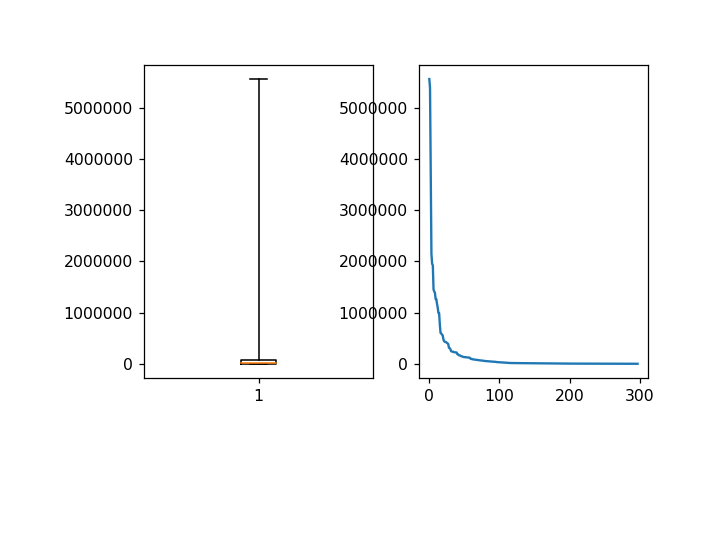

In [2]:
all_wikipedias = pd.read_csv('list_wikipedias.csv', sep='\t',
                             usecols=['Language', 'Wiki', 'Articles'], 
                            )

#print(all_wikipedias.head())
all_wikipedias.Articles = all_wikipedias.Articles.map(lambda x: int(x.replace(',','')))
sorted_all_wiki = all_wikipedias.sort_values(by='Articles', ascending=False)

plt.figure()
plt.subplot(1, 2, 1)
plt.boxplot(sorted_all_wiki.Articles, whis='range')
plt.subplot(1,2,2)
plt.plot(all_wikipedias.Articles)
plt.subplots_adjust(bottom=0.30, left=0.2)


In [53]:
sorted_all_wiki[sorted_all_wiki.Articles>20000]

,Language,Wiki,Articles
0,English,en,5561186
1,Cebuano,ceb,5383117
2,Swedish,sv,3785766
3,German,de,2148466
4,French,fr,1952230
5,Dutch,nl,1922413
6,Russian,ru,1450471
7,Italian,it,1413979
8,Spanish,es,1385563
9,Polish,pl,1263336


## 2. Work with classifier output
Load the csv file, asign names to the colums, define type of data type per column

In [6]:
data = pd.read_csv('merged_output_5k.csv',
                   names = ["first","true_lang", "true_lang_id", "predicted_lang_id", "probabilities"],
                   delimiter = '=')
data = data.drop(['first'], axis=1)
regex1 = re.compile("\'(.*)\'")
regex2 = re.compile("(\d{1,3})\.0,")
regex3 = re.compile("(\[.*\])")
data['true_lang'] = data['true_lang'].apply(lambda x: regex1.findall(x)[0])
data['true_lang_id'] = data['true_lang_id'].apply(lambda x: regex2.findall(x)[0])
data['predicted_lang_id'] = data['predicted_lang_id'].apply(lambda x: regex2.findall(x)[0])
data['probabilities'] = data['probabilities'].apply(lambda x: regex3.findall(x)[0])
data['true_lang_id'] = pd.to_numeric(data["true_lang_id"])
data['predicted_lang_id'] = pd.to_numeric(data["predicted_lang_id"])
print (data.dtypes)
data.head()

true_lang            object
true_lang_id          int64
predicted_lang_id     int64
probabilities        object
dtype: object


,true_lang,true_lang_id,predicted_lang_id,probabilities
0,no,44,44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,fi,29,29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,zh,22,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,cs,32,32,"[0.0001, 0.0, 0.0, 0.0013, 0.0015, 0.0, 0.0, 0..."
4,ms,34,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
#INFER FROM DATA THE TRUE_LANG_ID AND WRITE OUT IN DICT TO WORK AFTER

In [8]:
string_indexer = data.drop_duplicates('true_lang')[['true_lang','true_lang_id']].set_index('true_lang_id').sort_index()
dict_si = string_indexer.to_dict()['true_lang']

dict_index = dict((v,k) for k,v in dict_si.items())


In [9]:
data['predicted_lang'] = data['predicted_lang_id'].map(dict_si)
data.head()

,true_lang,true_lang_id,predicted_lang_id,probabilities,predicted_lang
0,no,44,44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no
1,fi,29,29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fi
2,zh,22,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",zh
3,cs,32,32,"[0.0001, 0.0, 0.0, 0.0013, 0.0015, 0.0, 0.0, 0...",cs
4,ms,34,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ms


separate the probabilities in different columns

In [10]:
prob_names = list(map(lambda x: 'prob_'+x, dict_index))

df_probs = data.probabilities.str.slice(1,-1).str.split(',',expand=True).\
                astype(np.float).\
                rename(columns={key: value for (key, value) in enumerate(prob_names)})
df_probs.head()

,prob_ur,prob_ar,prob_en,prob_eo,prob_min,prob_uk,prob_el,prob_vi,prob_eu,prob_ceb,...,prob_war,prob_da,prob_sh,prob_ca,prob_no,prob_pl,prob_be,prob_sk,prob_gl,prob_hr
0,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,1.0,0.0000,0.0,0.000,0.0000,0.0000
1,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,0.0001,0.0,0.0,0.0013,0.0015,0.0,0.0,0.0,0.0002,0.0001,...,0.0003,0.0001,0.0001,0.0001,0.0,0.0003,0.0,0.002,0.0001,0.0002
4,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000


In [11]:
df = data.drop('probabilities', axis=1).join(df_probs)
df.head()

,true_lang,true_lang_id,predicted_lang_id,predicted_lang,prob_ur,prob_ar,prob_en,prob_eo,prob_min,prob_uk,...,prob_war,prob_da,prob_sh,prob_ca,prob_no,prob_pl,prob_be,prob_sk,prob_gl,prob_hr
0,no,44,44,no,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,1.0,0.0000,0.0,0.000,0.0000,0.0000
1,fi,29,29,fi,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,zh,22,22,zh,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,cs,32,32,cs,0.0001,0.0,0.0,0.0013,0.0015,0.0,...,0.0003,0.0001,0.0001,0.0001,0.0,0.0003,0.0,0.002,0.0001,0.0002
4,ms,34,34,ms,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000


## 3. Associate abbreviation and Language name

In [12]:
with open('lang_list.txt','r') as f:
    list_lang_abv = f.read().split('\n')  
    list_lang_abv.pop()

df_tested_lang = pd.DataFrame(list_lang_abv, columns=['Wiki'])
df_tested_lang = df_tested_lang.merge(all_wikipedias, 
                                how='left', 
                                left_on='Wiki', 
                                right_on='Wiki')[['Wiki','Language']]
df_tested_lang['lang_both'] = df_tested_lang.Language + " ("+df_tested_lang.Wiki+")"
df_tested_lang['lang_id'] = df_tested_lang['Wiki'].map(dict_index)
df_tested_lang = df_tested_lang.set_index('lang_id').sort_index()
df_tested_lang

,Wiki,Language,lang_both
lang_id,,,
0,ur,Urdu,Urdu (ur)
1,ar,Arabic,Arabic (ar)
2,en,English,English (en)
3,eo,Esperanto,Esperanto (eo)
4,min,Minangkabau,Minangkabau (min)
5,uk,Ukrainian,Ukrainian (uk)
6,el,Greek,Greek (el)
7,vi,Vietnamese,Vietnamese (vi)
8,eu,Basque,Basque (eu)


Make readable

## 3. Get and graph main metrics

In [19]:
def classifaction_report(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.strip().split('      ')
        row['lang'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

 Lets see accuracy and true labels where give to each language

In [20]:
#following line not necesarry. taken from report df
#true_labels = df.groupby('true_lang')['true_lang_id'].count()

report = sk.metrics.classification_report(df.true_lang_id, df.predicted_lang_id, target_names=dict_index)

overall_accuracy = metrics.accuracy_score(df.true_lang_id, 
                                df.predicted_lang_id,)

df_report = classifaction_report(report)

df_report = df_report.merge(df_tested_lang, left_on='lang', right_on='Wiki').drop(['Wiki','Language'], axis=1).set_index('lang')
df_report.head(10)

,f1_score,precision,recall,support,lang_both
lang,,,,,
ur,1.00,1.00,1.00,955.0,Urdu (ur)
ar,1.00,1.00,1.00,951.0,Arabic (ar)
en,0.96,0.94,0.98,953.0,English (en)
eo,0.97,0.95,0.98,958.0,Esperanto (eo)
min,0.97,0.97,0.97,1011.0,Minangkabau (min)
uk,0.99,1.00,0.98,1007.0,Ukrainian (uk)
el,1.00,1.00,1.00,1005.0,Greek (el)
vi,1.00,1.00,1.00,997.0,Vietnamese (vi)
eu,0.99,0.99,0.99,952.0,Basque (eu)


In [21]:
df_report.recall.mean()

0.9597999999999999

In [22]:
def draw_two_barplot(num_xvalues, y_values_1, y_values_2, labels, title, 
                     y_label, x_label, 
                     filename, 
                     x_size = 35,
                     y_size = 5):
    fig = plt.figure(figsize=(x_size, y_size))
    
    xvals = range(1,num_xvalues+1)
    plt.bar(xvals, y_values_1, width = 0.25) #plot true_values
    plt.bar(xvals, y_values_2, width = 0.25 ,color='red') #plot predicted_values
    plt.xticks(xvals, labels, rotation='45')
    plt.gca().set_title(title)
    plt.gca().set_ylabel(y_label)
    plt.gca().set_xlabel(x_label)
    #plt.subplots_adjust(bottom=0.30, left=0.2)
    plt.tight_layout()
    plt.savefig(filename+'.jpg', bbox_inches="tight", dpi=300, )
    #fig.set_size_inches(20,15)
    

Barplot without normalizetion

<IPython.core.display.Javascript object>


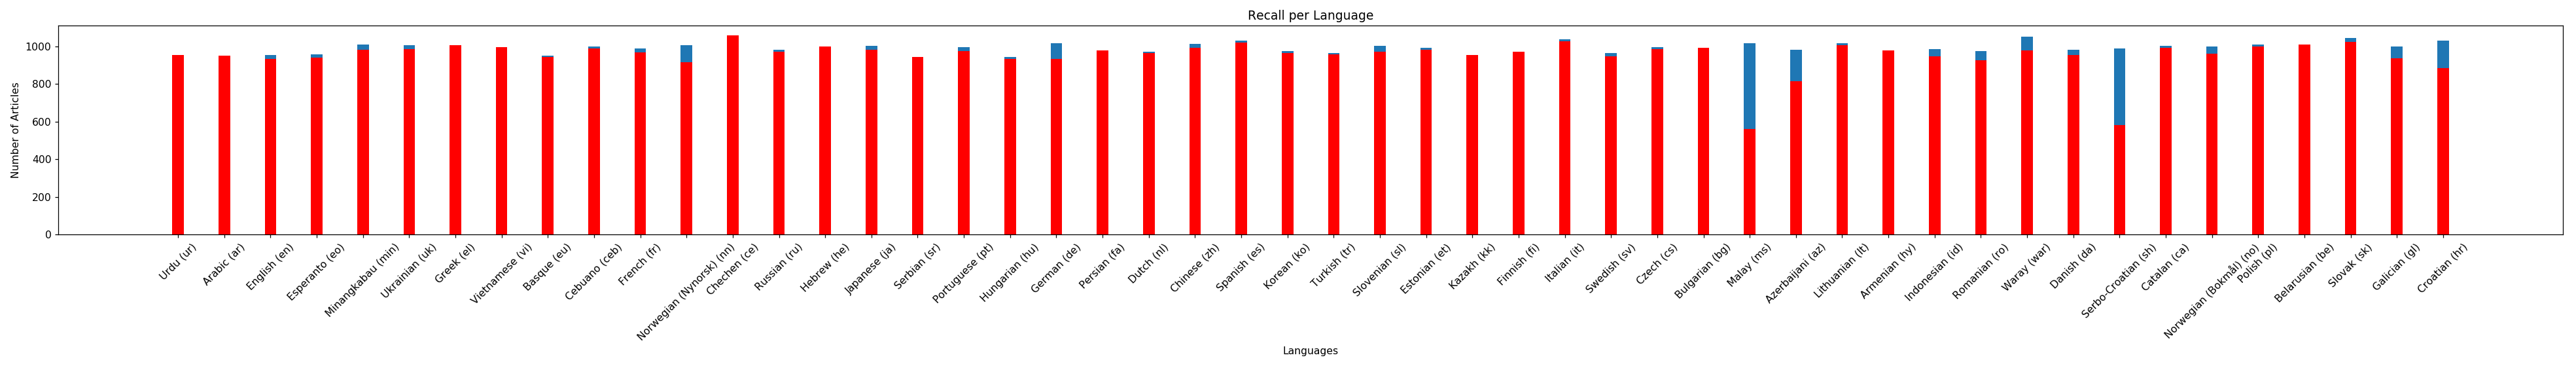

In [23]:
draw_two_barplot(len(df_report.index), 
                 df_report.support, 
                 df_report.support*df_report.recall, 
                 df_report.lang_both, 
                 'Recall per Language', 'Number of Articles', 'Languages',
                'recall_per_language')


<IPython.core.display.Javascript object>


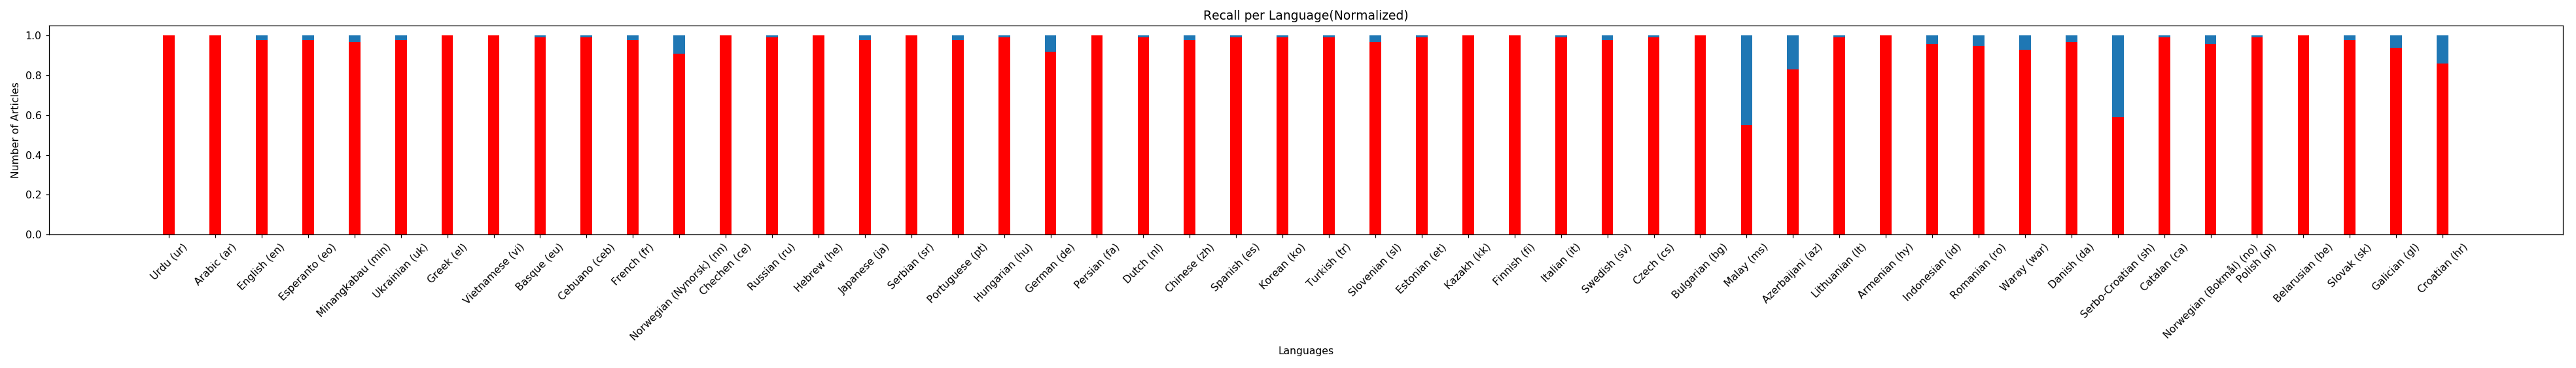

In [24]:
draw_two_barplot(len(df_report.index), 
                 [1]*len(df_report.index), 
                 df_report.recall, 
                 df_report.lang_both, 
                 'Recall per Language(Normalized)', 'Number of Articles', 'Languages',
                "recall_per_language_normalized")

## 4. Graph confusion Matrix

example taken from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [104]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          filename = "file"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid('off')
    plt.tick_params(axis=u'both', which=u'both',length=0)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.subplots_adjust(bottom=0.20, left=0.1)
    #plt.tight_layout()
    plt.savefig(filename+'.jpg', bbox_inches="tight", dpi=200, )
    

<IPython.core.display.Javascript object>


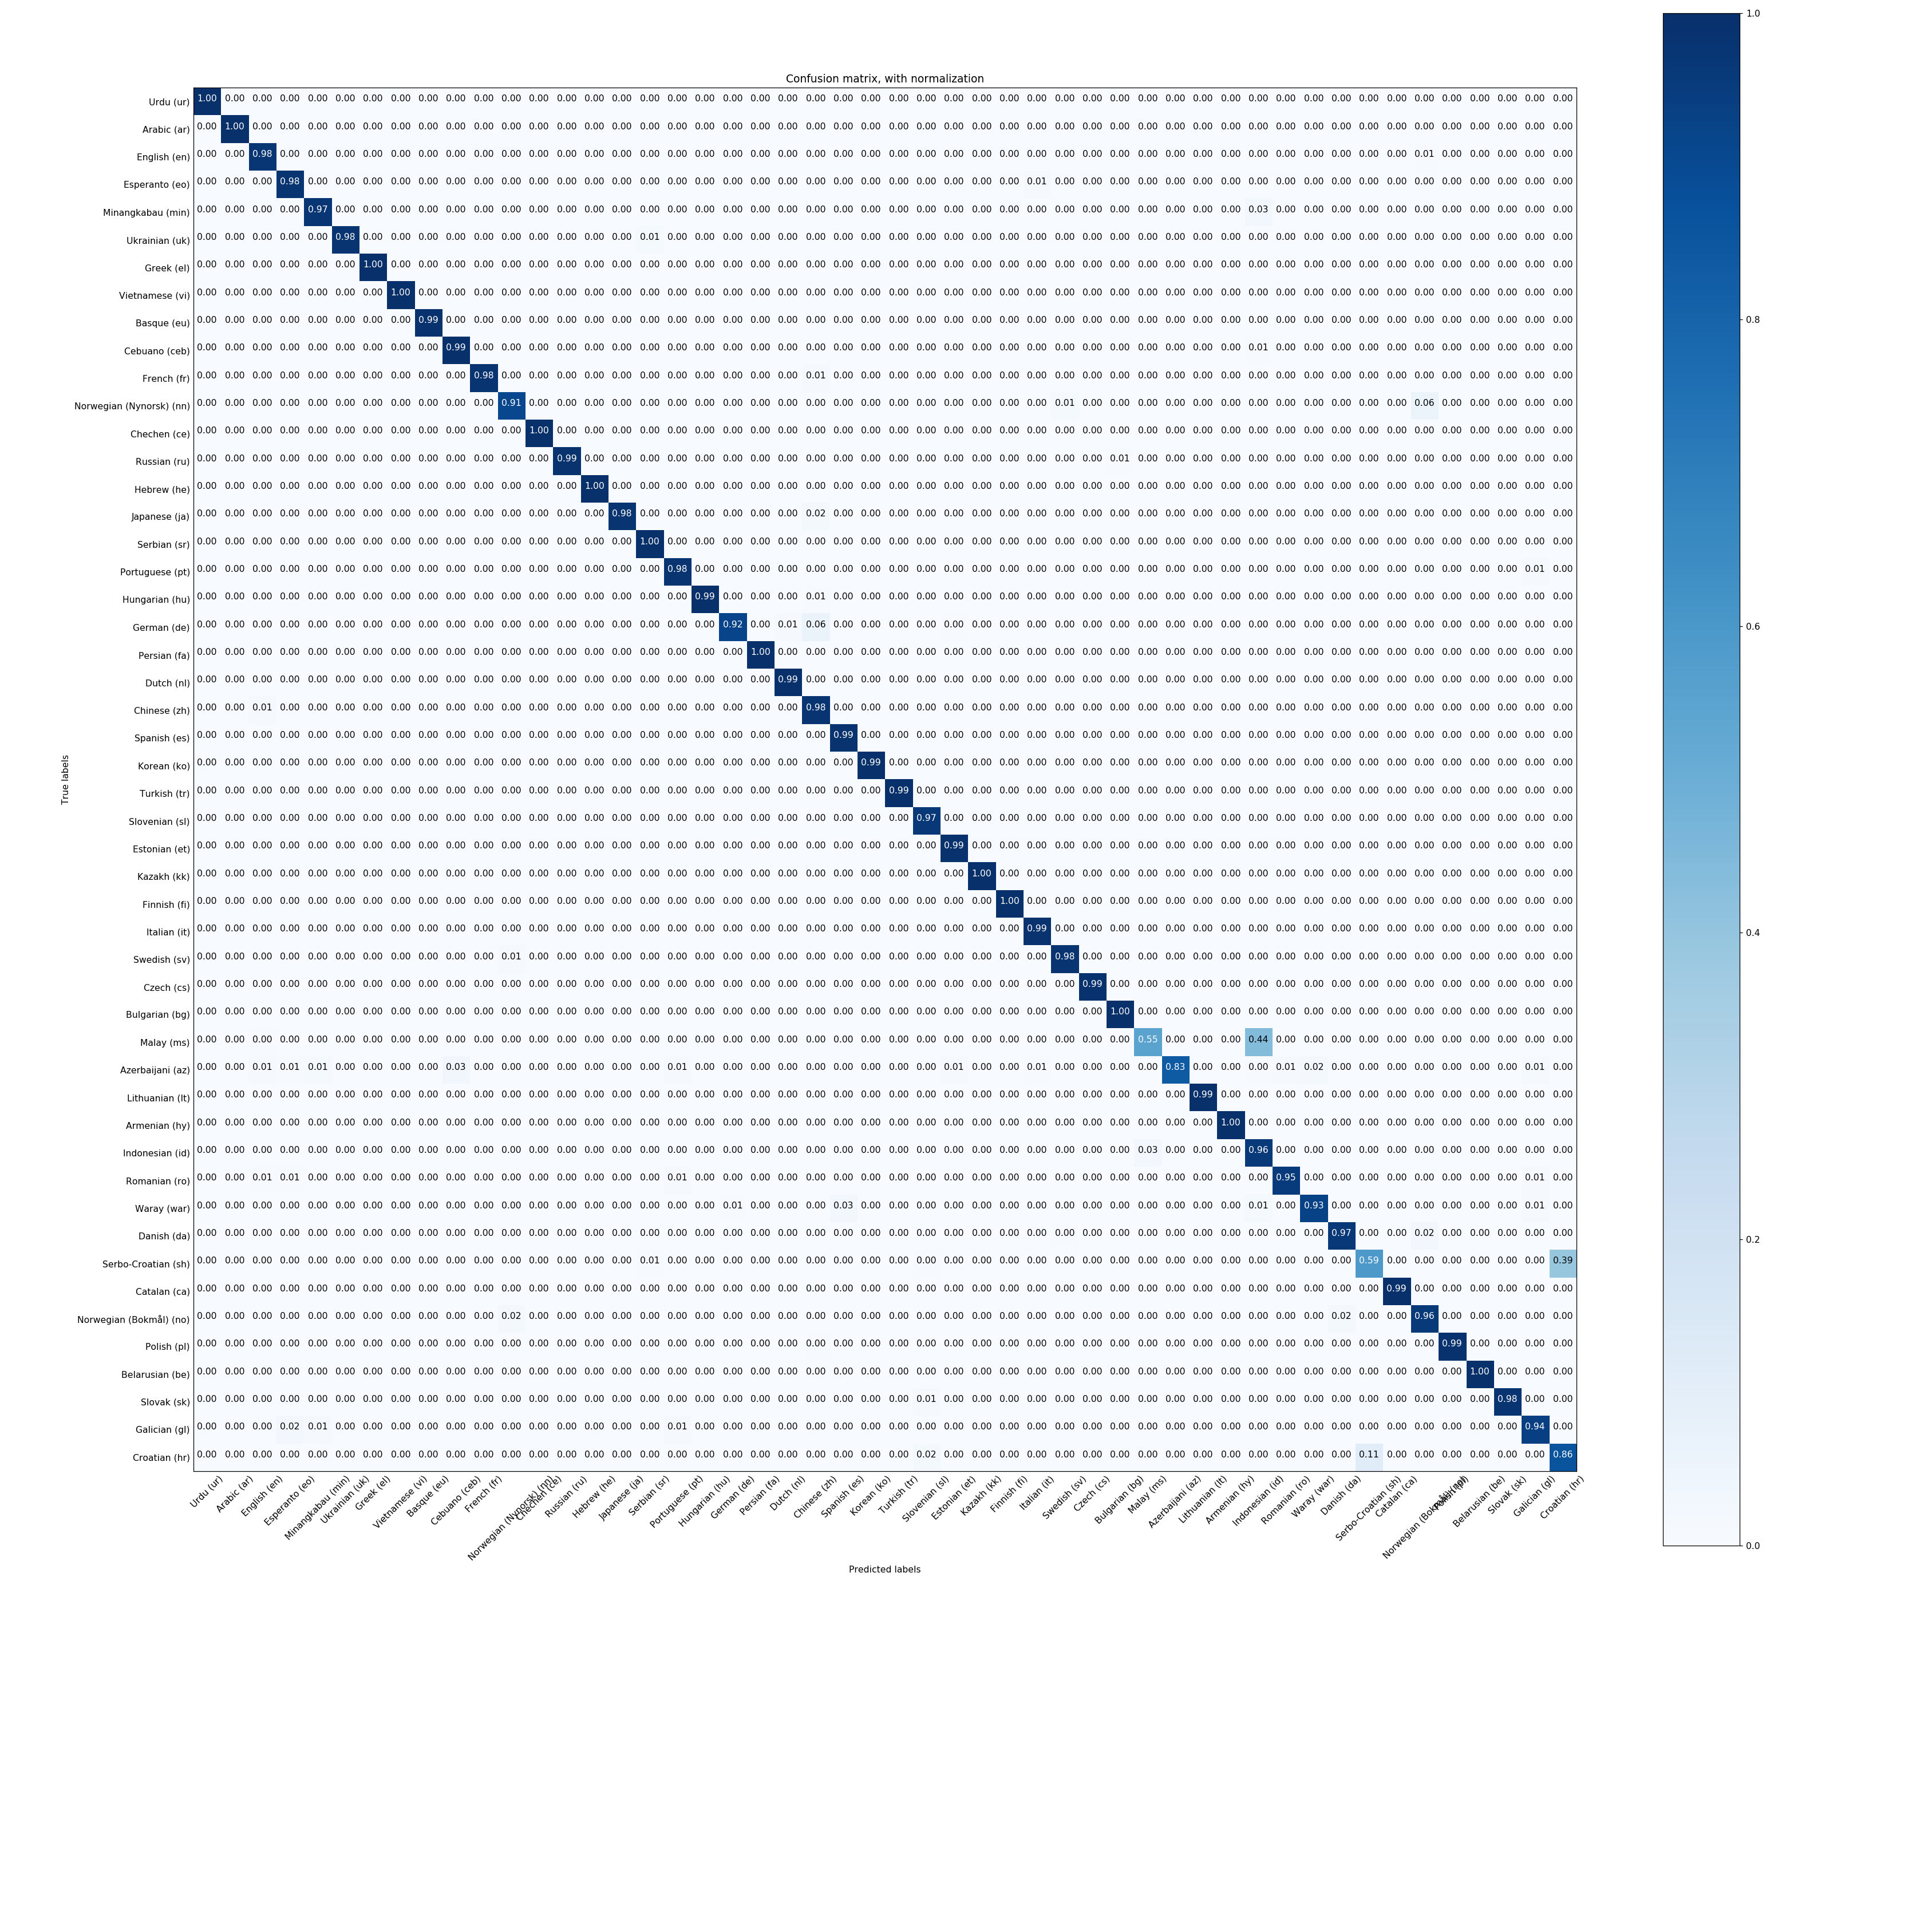

Normalized confusion matrix


In [106]:
cnf_matrix = sk.metrics.confusion_matrix(df.true_lang_id, df.predicted_lang_id)
plt.figure(figsize=(30, 30))
plot_confusion_matrix(cnf_matrix, classes=df_tested_lang.lang_both.tolist(),
                      title='Confusion matrix, with normalization',
                      filename = 'confusion_matrix_normalization')

    

<IPython.core.display.Javascript object>


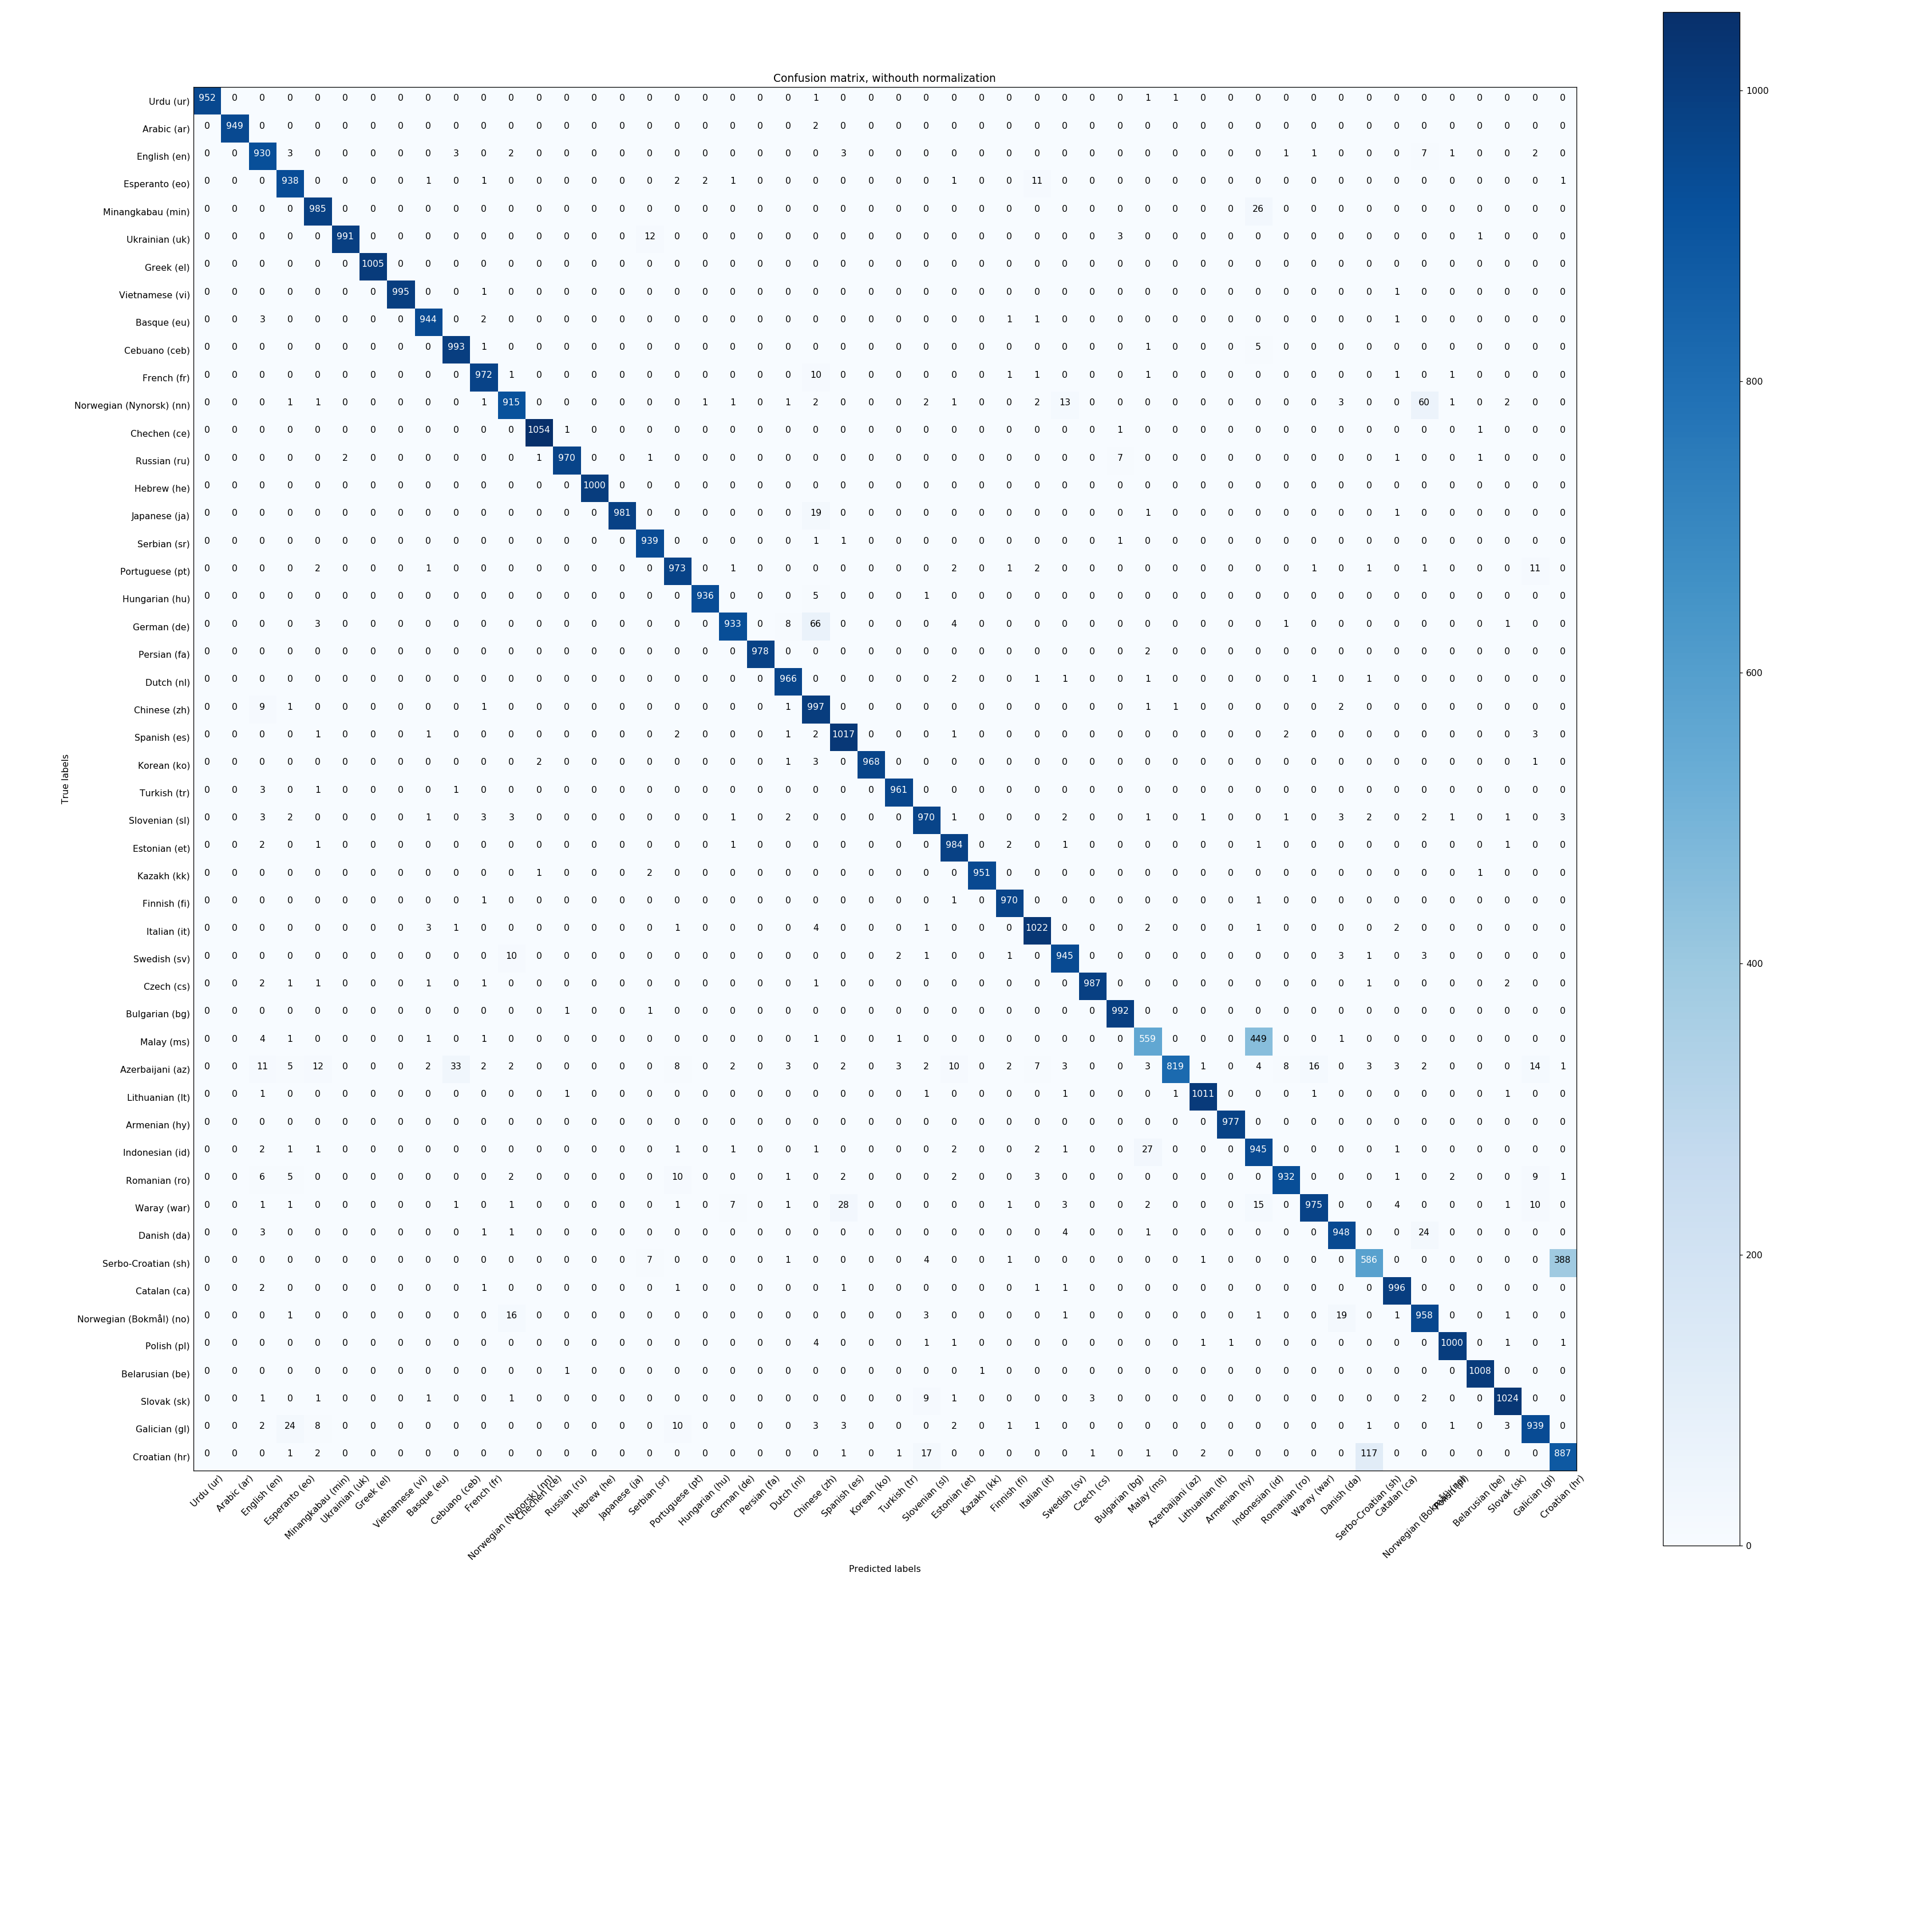

Confusion matrix, without normalization


In [107]:
plt.figure(figsize=(30, 30))
plot_confusion_matrix(cnf_matrix, classes=df_tested_lang.lang_both.tolist(),
                      normalize=False,
                      title='Confusion matrix, withouth normalization',
                      filename = 'confusion_matrix')

## 5. Show n worst performance languages

<IPython.core.display.Javascript object>


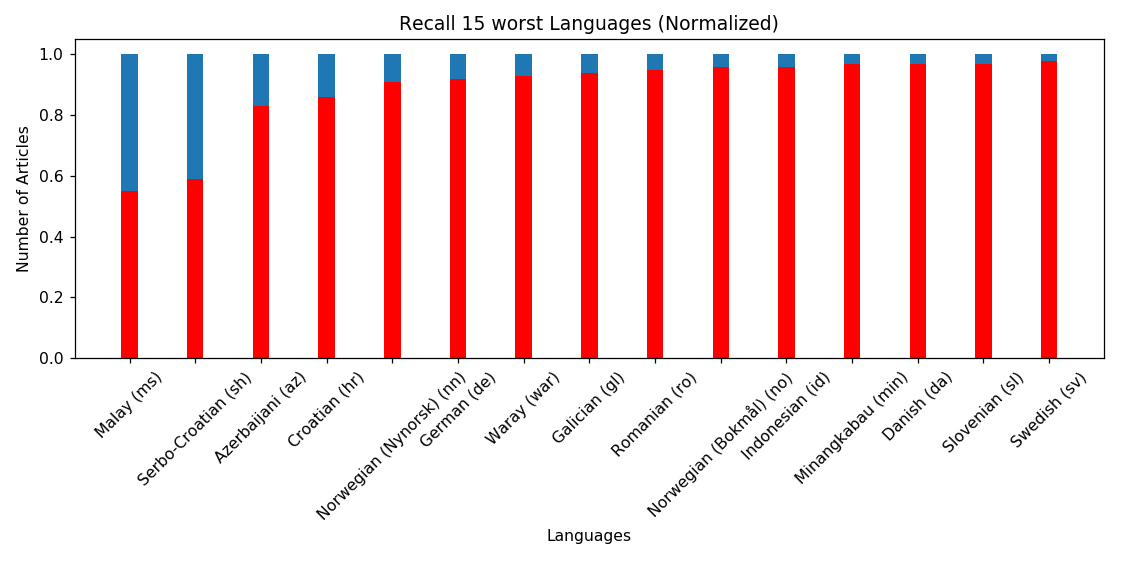

In [25]:
#set n
n = 15
df_sorted_report = df_report.sort_values(by='recall', ascending=True)

draw_two_barplot(n, 
                 [1]*n, 
                 df_sorted_report.recall[:n], 
                 df_sorted_report.lang_both[:n], 
                 'Recall {0} worst Languages (Normalized)'.format(n), 
                 'Number of Articles', 'Languages',
                 "worst_lang",
                 x_size = 10)

## 6. Choose a language and observe the clasification probabilities

In [26]:
df_sorted_report.head(15)

,f1_score,precision,recall,support,lang_both
lang,,,,,
ms,0.69,0.93,0.55,1018.0,Malay (ms)
sh,0.69,0.82,0.59,988.0,Serbo-Croatian (sh)
az,0.91,1.00,0.83,983.0,Azerbaijani (az)
hr,0.77,0.69,0.86,1030.0,Croatian (hr)
nn,0.93,0.96,0.91,1007.0,Norwegian (Nynorsk) (nn)
de,0.95,0.98,0.92,1016.0,German (de)
war,0.95,0.98,0.93,1052.0,Waray (war)
gl,0.95,0.95,0.94,998.0,Galician (gl)
ro,0.97,0.99,0.95,976.0,Romanian (ro)


In [117]:
#choose lang
lang_wiki = 'sh'

df_one_lang = df.groupby(by='true_lang').get_group(lang_wiki) #group by chose lang
df_count_class = df_one_lang[['true_lang','predicted_lang']]
df_count_class.groupby('predicted_lang').count()

,true_lang
predicted_lang,
fi,1
hr,388
lt,1
nl,1
sh,586
sl,4
sr,7


In [115]:
#df_misslabeled = df_one_lang[df_one_lang.true_lang_id != df_one_lang.predicted_lang_id] #only keep the misslabeled
#df_misslabeled = df_misslabeled.reset_index().drop('index', axis=1)
#df_misslabeled['pred_true_diff'] = 0
#for index, row in df_misslabeled.iterrows():
#    tmp1 = list_lang_abv[row.loc['true_lang_id']]
#    tmp2 = list_lang_abv[row.loc['predicted_lang_id']]
#    df_misslabeled.set_value(index, 'pred_true_diff', abs(row.loc['prob_'+lang_wiki] - row.loc['prob_'+tmp2]))
#    
#df_misslabeled[['true_lang','true_lang_id','predicted_lang_id','pred_true_diff']]
